# Spread Spectrum Watermarking

Previously we have seen LSB embedding and detection technique.

LSB is extremely trivial, so this time we will use Spread Spectrum watermarking.

Spread Spectrum watermarking: an independent and identically distributed (i.i.d) Gaussian random vector (the watermark) is **imperceptibly** inserted in a **spread-spectrum-like fashion** into the perceptually most significant spectral components of the data.

In [1]:
import os
from math import sqrt

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import dct, idct
from scipy.signal import convolve2d
from skimage.util import random_noise

## Embedding

In [2]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + (alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct, axis=1, norm='ortho'), axis=0, norm='ortho'))

    return mark, watermarked

# mark, watermarked = embedding(image, mark_size, alpha, v)
# cv2.imwrite('watermarked.bmp', watermarked)

## Quality

In [3]:
def wpsnr(img1, img2):
    img1 = np.float32(img1) / 255.0
    img2 = np.float32(img2) / 255.0

    difference = img1 - img2
    same = not np.any(difference)
    if same is True:
        return 9999999
    csf = np.genfromtxt('csf.csv', delimiter=',')
    ew = convolve2d(difference, np.rot90(csf, 2), mode='valid')
    decibels = 20.0 * np.log10(1.0 / sqrt(np.mean(np.mean(ew ** 2))))
    return decibels

# Plot the two images side by side
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarked,cmap='gray')
# plt.show()
#
# # Compute quality
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
# w = wpsnr(image, watermarked)
# print('wPSNR: %.2fdB' % w)

## EXERCISES:

1. Implement the detection for the Spred Spectrum
2. Change the value of alpha
3. Change the size of the watermark
4. Compute the PSNR and WPSNR of watermarked images for 3 different values of alpha in the multiplicative version of the SS
5. Implement the detection
6. Can you still detect the watermark if the image is attacked? Use different image processing techniques to see how the affect detection.
7. Play with the complete SS code (embedding + detection) and see what happens if you select different coefficients (e.g. low to mid frequencies) or if you embed the watermark only on some areas of the original image (thus, selecting areas in the spatial domain and exploiting block DCT instead of full frame DCT to perform the embedding).
8. We have seen how to embed and extract a watermark into the perceptually most significant spectral components of the data. This should allow to achieve robustness and imperceptibility. Can we do better? How?




## Detection

In [4]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    watermarked_dct = dct(dct(watermarked, axis=0, norm='ortho'), axis=1, norm='ortho')
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # This for the watermarked one
    watermarked_dct = abs(watermarked_dct)

    # Load the watermark
    w1 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:(mark_size + 1)]):
        if v == 'additive':
            w1[idx] = (watermarked_dct[loc] - ori_dct[loc]) / alpha
        elif v == 'multiplicative':
            w1[idx] = (watermarked_dct[loc] - ori_dct[loc]) / (alpha * ori_dct[loc])

    return w1

# w_ex = detection(image, watermarked, alpha, mark_size, v)

## Deciding whether the mark is present or not using a threshold

In [5]:
def similarity(X, X_star):
    # Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))

    if s < 0:
        return 0

    return s


def compute_thr(sim_self, mark_size, w):
    list = [sim_self]
    for i in range(999):
        _m = np.random.uniform(0.0, 1.0, mark_size)
        _m = np.uint8(np.rint(_m))

        __sim = similarity(w, _m)
        list.append(__sim)

    list.sort()
    return 1.1 * (list[-2])

# sim = similarity(w, w)
# T = compute_thr(sim, mark_size, w)
#
# if sim > T:
#     print(f'Mark has been found. SIM = {sim}, THR = {T}')
# else:
#     print(f'Mark has been lost. SIM = {sim}, THR = {T}')

## Attacking the watermark

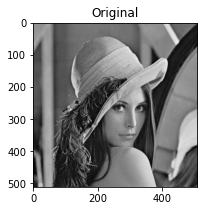

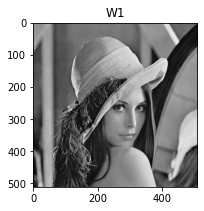

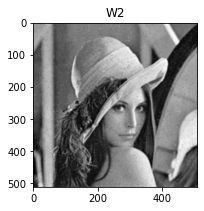

Watermarked:
Mark has been found. SIM = 11.48778976619094, THR = 7.755159572826339
PSNR: 38.44dB
wPSNR: 44.67dB
Attacked:
Mark has been found. SIM = 8.38347728654028, THR = 7.818862793566299
PSNR: 29.18dB
wPSNR: 36.88dB


In [7]:
def blur(img, sigma):
    from scipy.ndimage.filters import gaussian_filter
    attacked = gaussian_filter(img, sigma)
    return attacked


def sharpening(img, sigma, alpha):
    from scipy.ndimage import gaussian_filter

    #print(img/255)
    filter_blurred_f = gaussian_filter(img, sigma)

    attacked = img + alpha * (img - filter_blurred_f)
    return attacked


def do_shit(__image, __watermarked, alpha, mark_size, v, w):
    w_ex = detection(__image, __watermarked, alpha, mark_size, v)
    sim_self = similarity(w, w)
    sim_wt = similarity(w, w_ex)
    T = compute_thr(sim_self, mark_size, w)
    if sim_wt > T:
        print(f'Mark has been found. SIM = {sim_wt}, THR = {T}')
    else:
        print(f'Mark has been lost. SIM = {sim_wt}, THR = {T}')

    # Compute quality
    psnr = cv2.PSNR(__image, __watermarked)
    print('PSNR: %.2fdB' % psnr)
    w = wpsnr(__image, __watermarked)
    print('wPSNR: %.2fdB' % w)


# get required images
if not os.path.isfile('lena.bmp'):
    !wget -O lena.bmp "https://drive.google.com/uc?export=download&id=17MVOgbOEOqeOwZCzXsIJMDzW5Dw9-8zm"
if not os.path.isfile('csf.csv'):
    !wget -O csf.csv "https://drive.google.com/uc?export=download&id=1w43k1BTfrWm6X0rqAOQhrbX6JDhIKTRW"

# define settings
img_path = 'lena.bmp'
mark_size = 256
alpha = 0.11
v = 'multiplicative'
#np.random.seed(seed=123)

original = cv2.imread(img_path, 0)
mark, watermarked = embedding(original, mark_size, alpha, v)

if True:
    # Show orginal and edited images side by side
    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original, cmap='gray')

    plt.figure(figsize=(10, 6))
    plt.subplot(132)
    plt.title('W1')
    plt.imshow(watermarked, cmap='gray')

    # Add salt-and-pepper noise to the image.
    attacked = random_noise(watermarked, mode='s&p', amount=0.012)
    attacked = np.array(255 * attacked, dtype='uint8')
    attacked = cv2.blur(attacked, (4, 4))

    plt.figure(figsize=(10, 6))
    plt.subplot(133)
    plt.title('W2')
    plt.imshow(attacked, cmap='gray')
    plt.show()

print("Watermarked:")
do_shit(original, watermarked, alpha, mark_size, v, mark)

print("Attacked:")
do_shit(original, attacked, alpha, mark_size, v, mark)